In [1]:
import sys

sys.path.append('../..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.api.types

from wildlife_datasets.datasets.utils import find_images
from wildlife_datasets.metrics import BAKS, BAUS

In [2]:
def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame
    ) -> dict:

    submission = submission.reset_index(drop=True)
    solution = solution.reset_index(drop=True)

    # Checks for correct input format
    if 'image_id' not in submission.columns:
        return np.nan
    if 'identity' not in submission.columns:
        return np.nan
    if len(submission) != len(solution):
        return np.nan
    if not np.array_equal(submission['image_id'], solution['image_id']):
        return np.nan
    if not pandas.api.types.is_string_dtype(submission['identity']):
        return np.nan
    if not solution['identity'].apply(lambda x: x.startswith('SeaTurtleID2022_') or x.startswith('SalamanderID2025_') or x.startswith('LynxID2025_') or x == 'new_individual').all():
        return np.nan

    # Extract the data
    results = {}
    unknown_identities = solution[solution['new_identity']]['identity'].unique()
    for name, solution_dataset in solution.groupby('dataset'):
        predictions = submission.loc[solution_dataset.index, 'identity'].to_numpy()
        labels = solution_dataset['identity'].to_numpy()
                
        # Compute the balances accuracies on known and unknown samples
        acc_known = BAKS(labels, predictions, unknown_identities)
        acc_unknown = BAUS(labels, predictions, unknown_identities, 'new_individual')

        # Compute precision
        unknown_true = np.isin(labels, unknown_identities)
        unknown_pred = predictions == 'new_individual'
        if sum(unknown_pred) == 0:
            precision = 0
        else:
            precision = sum(unknown_true*unknown_true) / sum(unknown_pred)

        # Fix possible nans
        if np.isnan(acc_known):
            acc_known = 0
        if np.isnan(acc_unknown):
            acc_unknown = 0

        # Save to dataframe
        results[name] = {
            'BAKS': acc_known,
            'BAUS': acc_unknown,
            'precision': precision,
            'normalized': np.sqrt(acc_known*acc_unknown)
        }
    results = pd.DataFrame(results).T

    results2 = {}
    cols = ['BAKS', 'BAUS', 'precision', 'normalized']
    for col in cols:
        for name in solution['dataset'].unique():
            results2[f'{name}_{col}'] = results.loc[name, col]
        results2[col] = results[col].mean()

    return results2

In [3]:
root = '/data/wildlife_datasets/data/AnimalCLEF2025'
n_max = 50

solution = pd.read_csv(f'{root}/solution.csv')
sample_submission = pd.read_csv(f'{root}/sample_submission.csv')
idx_public = solution['Usage'] == 'Public'

root_submission = f'{root}/submissions'
df_submission = find_images(root_submission, img_extensions='.csv')

In [4]:
results_public = {}
results_private = {}
for participant, df_participant in df_submission.groupby('path'):
    results_participant = {'private': {}, 'public': {}}
    for i, (_, df_row) in enumerate(df_participant.sort_values('file').iterrows()):
        submission = pd.read_csv(f'{root_submission}/{df_row["path"]}/{df_row["file"]}')

        if solution.index.equals(submission.index):
            score_public = score(solution[idx_public], submission[idx_public])
            score_private = score(solution[~idx_public], submission[~idx_public])
        else:
            score_public = np.nan
            score_private = np.nan
        results_participant['public'][i] = score_public
        results_participant['private'][i] = score_private
    results_public[participant] = pd.DataFrame(results_participant['public']).T
    results_private[participant] = pd.DataFrame(results_participant['private']).T

In [5]:
results = {}
names_datasets = ['LynxID2025', 'SalamanderID2025', 'SeaTurtleID2022']
cols_normalized = [name + '_normalized' for name in names_datasets]
for participant in results_public.keys():
    i_max = results_public[participant]['normalized'].argmax()
    results[participant] = results_private[participant].iloc[i_max]
results = pd.DataFrame(results).T

index_new = []
index_manual = {
    9: 'XiangYuhang', # 项宇航
    11: 'XuZhe', # 许喆
}
for i, x in enumerate(results.index):
    x_split = x.split(' ')
    if len(x_split) >= 2:
        x_new = ' '.join(x_split[1:])
    else:
        x_new = index_manual[i+1]
    x_new = x_new.replace('_', '\_')
    index_new.append(x_new)

results.index = index_new
results.insert(0, 'rank', range(1,len(results)+1))
results.to_csv('results.csv', index_label='team')

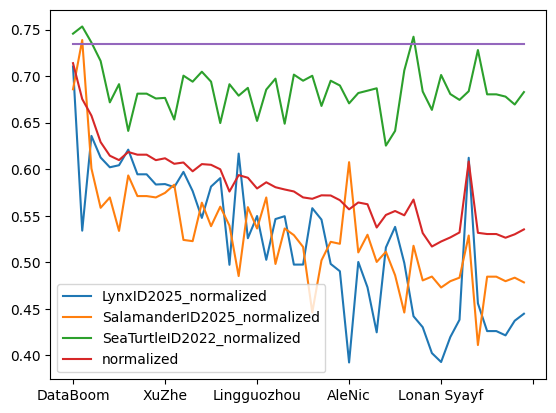

In [6]:
utopia_score = results[cols_normalized].max().mean()
results[cols_normalized + ['normalized']].iloc[:n_max].plot()
plt.plot([0, n_max-1], [utopia_score, utopia_score])

<Axes: >

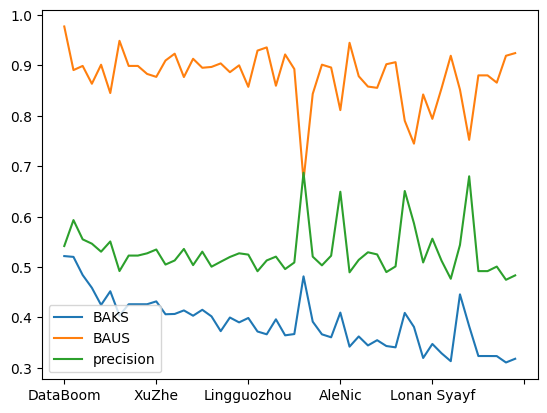

In [7]:
results[['BAKS', 'BAUS', 'precision']].iloc[:n_max].plot()

In [8]:
val1 = score(solution[~idx_public], sample_submission[~idx_public])
val2 = utopia_score

print(val1)
print(val2, results['normalized'].iloc[0], results['normalized'].iloc[1])

{'LynxID2025_BAKS': 0.09769639957447838, 'SalamanderID2025_BAKS': 0.20710059171597603, 'SeaTurtleID2022_BAKS': 0.323, 'BAKS': 0.2092656637634848, 'LynxID2025_BAUS': 0.9954887218045108, 'SalamanderID2025_BAUS': 0.9807692307692316, 'SeaTurtleID2022_BAUS': 1.0000000000000004, 'BAUS': 0.9920859841912476, 'LynxID2025_precision': 0.3022875816993464, 'SalamanderID2025_precision': 0.35036496350364965, 'SeaTurtleID2022_precision': 0.592057761732852, 'precision': 0.4149034356452827, 'LynxID2025_normalized': 0.31185840366631173, 'SalamanderID2025_normalized': 0.4506860193406608, 'SeaTurtleID2022_normalized': 0.5683308895353131, 'normalized': 0.4436251041807619}
0.7340981973480062 0.7138852109850001 0.6753256201601495
